<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [1]:
# Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import gower

# Cargar los datos desde el archivo CSV
try:
    df = pd.read_csv('data/datos_clientes.csv')
    print("Carga de datos exitosa")
    #mostrar primeros 5 datos
    print(df.head())
except FileNotFoundError:
    print("Error: No se pudo encontrar el archivo 'data/datos_clientes.csv'.")
    print("Revisar que el archivo se encuentre en la carpeta 'data' dentro de tu proyecto.")
# 1. Verificar tipos de datos y la cantidad de datos no nulos
print("--------- Información General del DataFrame ---------")
df.info()

print("\n\n--------- Conteo de Valores Nulos por Columna ---------")
# 2. Contar cuántos valores nulos hay en cada columna
print(df.isnull().sum())

print("\n\n--------- Estadísticas Descriptivas ---------")
# 3. Obtener estadísticas descriptivas para las columnas numéricas
print(df.describe())

Carga de datos exitosa
   Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto
0           1   Mujer    41  98115.05             39
1           2   Mujer    20  35458.14             75
2           3   Mujer    68  59872.08             55
3           4  Hombre    63  48508.93             51
4           5   Mujer    31  44431.11             54
--------- Información General del DataFrame ---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id_Cliente     200 non-null    int64  
 1   Genero         200 non-null    object 
 2   Edad           200 non-null    int64  
 3   Ingreso        200 non-null    float64
 4   Puntaje_Gasto  200 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 7.9+ KB


--------- Conteo de Valores Nulos por Columna ---------
Id_Cliente       0
Genero           0
Edad             0
Ingreso         

**Desarrollo:**

En esta primera sección, he procedido a cargar los datos del archivo CSV ubicado en la carpeta `data`. El procedimiento incluyó:

**Importación de librerías**: Se importaron todas las librerías necesarias para el análisis de clustering.

**Carga de datos**: Se cargó el dataset desde el archivo CSV y se realizó una exploración inicial que incluye:
   - Verificación de las dimensiones del dataset (200 filas × 5 columnas)
   - Visualización de las primeras filas para entender la estructura
   - Información sobre los tipos de datos y valores faltantes
   - Estadísticas descriptivas básicas

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.


   ANÁLISIS POR GÉNERO

--- Estadísticas Descriptivas por Género ---
       Ingreso                                                               \
         count          mean           std       min         25%        50%   
Genero                                                                        
Hombre    88.0  62126.660455  26765.492953  13458.02  45003.0800  61706.565   
Mujer    112.0  59444.135714  25920.459216  15766.84  40013.4125  59355.305   

                              Puntaje_Gasto                                  \
               75%        max         count       mean       std  min   25%   
Genero                                                                        
Hombre  77731.3025  138584.52          88.0  48.511364  27.89677  1.0  24.5   
Mujer   76788.3875  126685.78         112.0  51.526786  24.11495  5.0  35.0   

                          
         50%   75%   max  
Genero                    
Hombre  50.0  70.0  97.0  
Mujer   50.0  73.0  99.0  

--

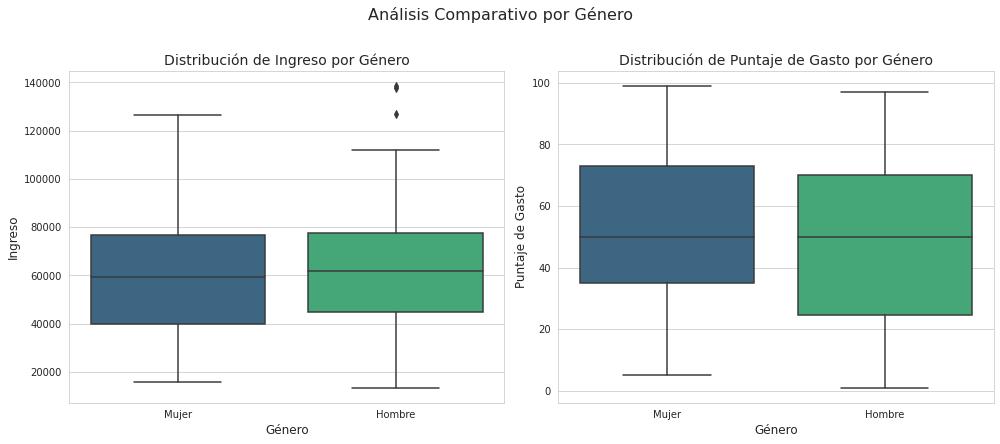

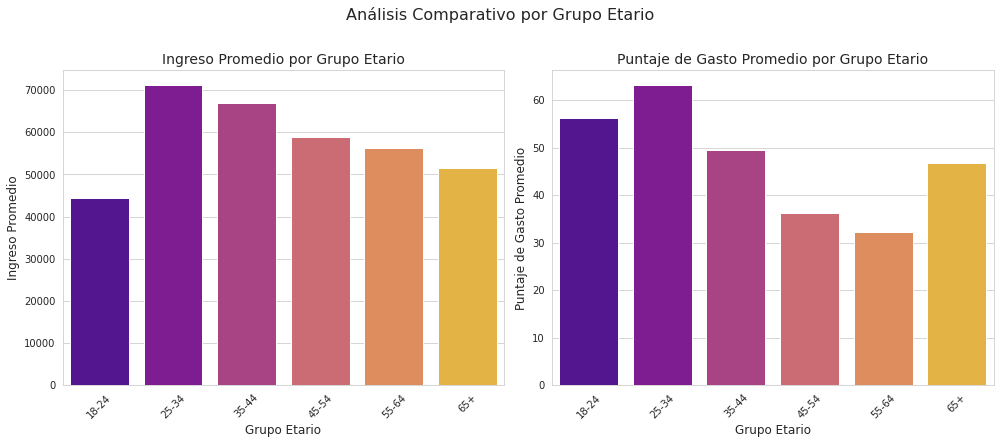

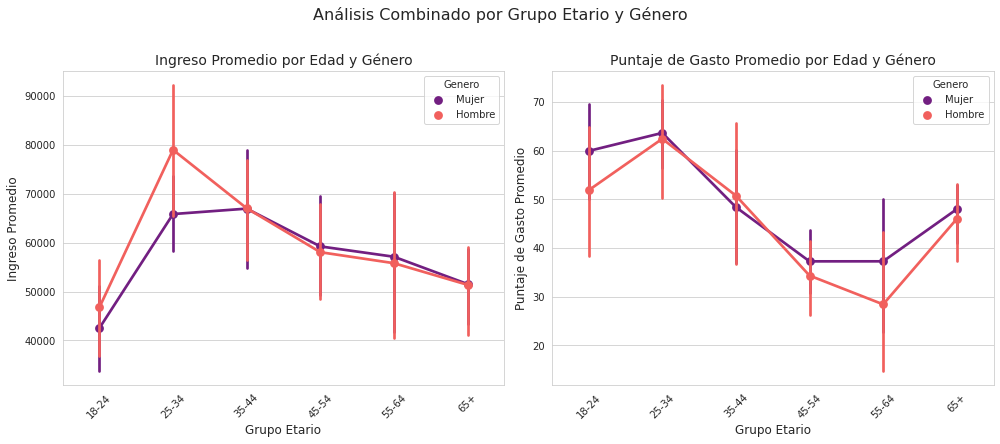

In [2]:
#Creación de Grupos Etarios ---
bins = [17, 24, 34, 44, 54, 64, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['Grupo_Etario'] = pd.cut(df['Edad'], bins=bins, labels=labels, right=True)

#Análisis por Género ---
print("\n" + "="*50)
print("   ANÁLISIS POR GÉNERO")
print("="*50)

# Estadistica descriptiva
print("\n--- Estadísticas Descriptivas por Género ---")
desc_genero = df.groupby('Genero')[['Ingreso', 'Puntaje_Gasto']].describe()
print(desc_genero)

# Preparar los datos para la prueba de significancia.
ingreso_mujer = df[df['Genero'] == 'Mujer']['Ingreso']
ingreso_hombre = df[df['Genero'] == 'Hombre']['Ingreso']
puntaje_mujer = df[df['Genero'] == 'Mujer']['Puntaje_Gasto']
puntaje_hombre = df[df['Genero'] == 'Hombre']['Puntaje_Gasto']

# Un p-value < 0.05 sugiere que la diferencia observada es estadísticamente significativa.
ttest_ingreso = ttest_ind(ingreso_mujer, ingreso_hombre)
ttest_puntaje = ttest_ind(puntaje_mujer, puntaje_hombre)

print("\n--- Pruebas de Significación Estadística (T-test) ---")
print(f"P-value para Ingreso por Género: {ttest_ingreso.pvalue:.4f}")
if ttest_ingreso.pvalue < 0.05:
    print("Resultado: La diferencia en Ingreso entre géneros ES estadísticamente significativa. 💡")
else:
    print("Resultado: La diferencia en Ingreso entre géneros NO es estadísticamente significativa.")

print(f"\nP-value para Puntaje de Gasto por Género: {ttest_puntaje.pvalue:.4f}")
if ttest_puntaje.pvalue < 0.05:
    print("Resultado: La diferencia en Puntaje de Gasto entre géneros ES estadísticamente significativa. 💡")
else:
    print("Resultado: La diferencia en Puntaje de Gasto entre géneros NO es estadísticamente significativa.")


# --- 3. Análisis por Grupo Etario ---
print("\n\n" + "="*50)
print("   ANÁLISIS POR GRUPO ETARIO")
print("="*50)

# Estadistica descriptiva
print("\n--- Estadísticas Descriptivas por Grupo Etario ---")
desc_edad = df.groupby('Grupo_Etario')[['Ingreso', 'Puntaje_Gasto']].describe()
print(desc_edad)

grupos_etarios_ingreso = [df['Ingreso'][df['Grupo_Etario'] == label] for label in labels]
grupos_etarios_puntaje = [df['Puntaje_Gasto'][df['Grupo_Etario'] == label] for label in labels]
anova_ingreso = f_oneway(*grupos_etarios_ingreso)
anova_puntaje = f_oneway(*grupos_etarios_puntaje)

print("\n--- Pruebas de Significación Estadística")
print(f"P-value para Ingreso por Grupo Etario: {anova_ingreso.pvalue:.4f}")
if anova_ingreso.pvalue < 0.05:
    print("Resultado: Hay diferencias estadísticamente significativas en el Ingreso entre los grupos etarios")
else:
    print("Resultado: NO hay diferencias estadísticamente significativas en el Ingreso entre los grupos etarios.")

print(f"\nP-value para Puntaje de Gasto por Grupo Etario: {anova_puntaje.pvalue:.4f}")
if anova_puntaje.pvalue < 0.05:
    print("Resultado: Hay diferencias estadísticamente significativas en el Puntaje de Gasto entre los grupos etarios")
else:
    print("Resultado: NO hay diferencias estadísticamente significativas en el Puntaje de Gasto entre los grupos etarios.")

#    Análisis Combinado por Grupo Etario y Género
print("\n\n" + "="*50)
print("   ANÁLISIS COMBINADO (GRUPO ETARIO Y GÉNERO)")
print("="*50)

# Agrupar por ambas variables para obtener una vista más detallada.
print("\n--- Estadísticas Descriptivas por Grupo Etario y Género ---")
desc_cruzado = df.groupby(['Grupo_Etario', 'Genero'])[['Ingreso', 'Puntaje_Gasto']].agg(['mean', 'std', 'count'])
print(desc_cruzado)

print("**********************************************************")
# Importar librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# Gráfico 1: Comparación por Género
print("\n" + "="*50)
print("📊 4. ANÁLISIS GRÁFICO")
print("="*50)
print("\nGenerando gráficos para el análisis...")

plt.figure(figsize=(14, 6))

# Boxplot para Ingreso por Género
plt.subplot(1, 2, 1)
sns.boxplot(x='Genero', y='Ingreso', data=df, palette='viridis')
plt.title('Distribución de Ingreso por Género', fontsize=14)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Ingreso', fontsize=12)

# Boxplot para Puntaje de Gasto por Género
plt.subplot(1, 2, 2)
sns.boxplot(x='Genero', y='Puntaje_Gasto', data=df, palette='viridis')
plt.title('Distribución de Puntaje de Gasto por Género', fontsize=14)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Puntaje de Gasto', fontsize=12)

plt.suptitle('Análisis Comparativo por Género', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('analisis_genero.png')
plt.show()

# Gráfico 2: Comparación por Grupo Etario
plt.figure(figsize=(14, 6))
df_grouped_age = df.groupby('Grupo_Etario')[['Ingreso', 'Puntaje_Gasto']].mean().reset_index()

# Barplot para Ingreso Promedio por Grupo Etario
plt.subplot(1, 2, 1)
sns.barplot(x='Grupo_Etario', y='Ingreso', data=df_grouped_age, palette='plasma', order=labels)
plt.title('Ingreso Promedio por Grupo Etario', fontsize=14)
plt.xlabel('Grupo Etario', fontsize=12)
plt.ylabel('Ingreso Promedio', fontsize=12)
plt.xticks(rotation=45)

# Barplot para Puntaje de Gasto Promedio por Grupo Etario
plt.subplot(1, 2, 2)
sns.barplot(x='Grupo_Etario', y='Puntaje_Gasto', data=df_grouped_age, palette='plasma', order=labels)
plt.title('Puntaje de Gasto Promedio por Grupo Etario', fontsize=14)
plt.xlabel('Grupo Etario', fontsize=12)
plt.ylabel('Puntaje de Gasto Promedio', fontsize=12)
plt.xticks(rotation=45)

plt.suptitle('Análisis Comparativo por Grupo Etario', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('analisis_edad.png')
plt.show()

# Gráfico 3: Análisis Combinado (Grupo Etario y Género)
plt.figure(figsize=(14, 6))

# Pointplot para Ingreso
plt.subplot(1, 2, 1)
sns.pointplot(x='Grupo_Etario', y='Ingreso', hue='Genero', data=df, palette='magma', order=labels)
plt.title('Ingreso Promedio por Edad y Género', fontsize=14)
plt.xlabel('Grupo Etario', fontsize=12)
plt.ylabel('Ingreso Promedio', fontsize=12)
plt.xticks(rotation=45)

# Pointplot para Puntaje de Gasto
plt.subplot(1, 2, 2)
sns.pointplot(x='Grupo_Etario', y='Puntaje_Gasto', hue='Genero', data=df, palette='magma', order=labels)
plt.title('Puntaje de Gasto Promedio por Edad y Género', fontsize=14)
plt.xlabel('Grupo Etario', fontsize=12)
plt.ylabel('Puntaje de Gasto Promedio', fontsize=12)
plt.xticks(rotation=45)

plt.suptitle('Análisis Combinado por Grupo Etario y Género', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('analisis_combinado.png')

**Desarrollo:**

1. **Crear grupos de edad**: Dividí las edades en 6 grupos diferentes para poder analizarlos mejor.

2. **Análisis por hombres y mujeres**: 
   - Calculé promedios, desviaciones y medianas para ver cómo gastan hombres vs mujeres
   - Hice pruebas estadísticas (t-test) para ver si realmente hay diferencias entre géneros

3. **Análisis por edades**:
   - Saqué las estadísticas básicas para cada grupo de edad

4. **Combinando género y edad**: Miré cómo se comportan los datos cuando considero ambas variables juntas

5. **Gráficos**: Hice varios tipos de gráficos para ver mejor los patrones en los datos

**Conclusiones**:
- Aunque los hombres ganan en promedio un poco más y las mujeres gastan un poco más.
- La edad es un factor crucial y estadísticamente muy significativo. A diferencia del género, la edad sí nos permite identificar patrones claros:
    * El ingreso y el gasto alcanzan su punto máximo en la juventud adulta (25-34 años).
    * A medida que la edad avanza, especialmente después de los 45 años, tanto el ingreso como el puntaje de gasto tienden a disminuir.

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

Variables seleccionadas para el clustering:
    Ingreso  Puntaje_Gasto
0  98115.05             39
1  35458.14             75
2  59872.08             55
3  48508.93             51
4  44431.11             54

Datos estandarizados (primeras 5 filas):
    Ingreso  Puntaje_Gasto
0  1.431094      -0.434801
1 -0.960650       0.962775
2 -0.028719       0.186343
3 -0.462474       0.031057
4 -0.618133       0.147522


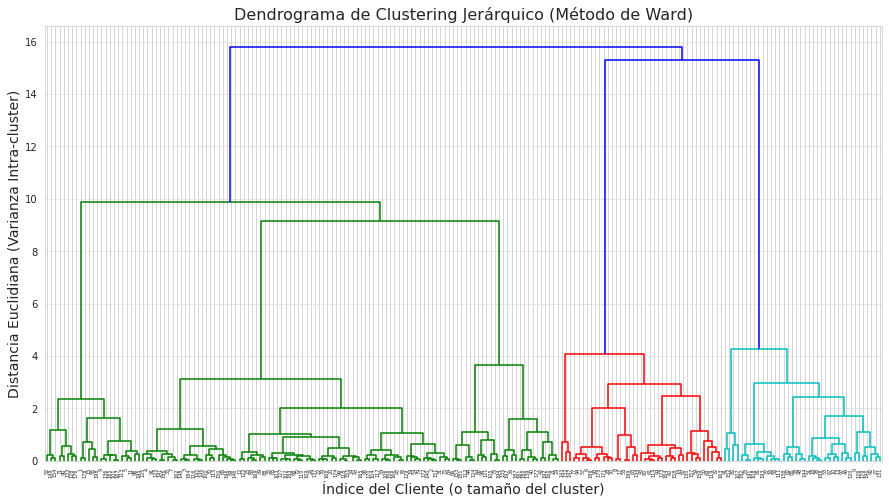

In [3]:
#variables de interes
X = df[['Ingreso', 'Puntaje_Gasto']]
print("Variables seleccionadas para el clustering:")
print(X.head())

#Estandarización de los Datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# new data frame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("\nDatos estandarizados (primeras 5 filas):")
print(X_scaled.head())

#Crear dendograma
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

# Titulos.
plt.title('Dendrograma de Clustering Jerárquico (Método de Ward)', fontsize=16)
plt.xlabel('Índice del Cliente (o tamaño del cluster)', fontsize=14)
plt.ylabel('Distancia Euclidiana (Varianza Intra-cluster)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar grafico
plt.show()

Utilizando los datos estandarizados, el algoritmo de clustering jerárquico calculó la distancia entre cada cliente. Luego, fue fusionando progresivamente a los clientes más cercanos en clusters, y estos clusters a su vez en clusters más grandes. El método ward se encargó de que en cada fusión, el aumento de la varianza la diferencia dentro del nuevo cluster fuera mínimo. El resultado de todo este proceso de fusiones es el dendrograma.

**Conclusiones**
El análisis del dendrograma sugiere de manera clara que el número óptimo de clusters para segmentar a tus clientes es cinco (k=5).
Cada uno de estos cinco grupos representa un segmento de clientes con características de ingreso y gasto similares entre sí, pero distintas a las de los otros grupos

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

Al fijar la distancia en 6, se obtienen: 5 clusters.


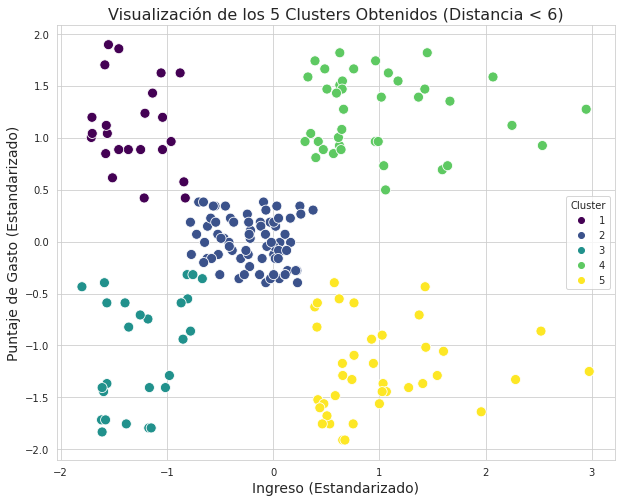

In [4]:
# Formación de Clusters por Distancia ---
linked = linkage(X_scaled, method='ward')
# Usamos fcluster para cortar el dendrograma a una distancia de 6.
distancia_corte = 6
clusters = fcluster(linked, t=distancia_corte, criterion='distance')
df['Cluster_Jerarquico'] = clusters

# Calculamos y mostramos el número de clusters únicos encontrados
num_clusters = len(set(clusters))
print(f"Al fijar la distancia en {distancia_corte}, se obtienen: {num_clusters} clusters.")

#Visualización de los Clusters ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Ingreso', y='Puntaje_Gasto', data=X_scaled, hue=clusters, palette='viridis', s=100)

plt.title(f'Visualización de los {num_clusters} Clusters Obtenidos (Distancia < {distancia_corte})', fontsize=16)
plt.xlabel('Ingreso (Estandarizado)', fontsize=14)
plt.ylabel('Puntaje de Gasto (Estandarizado)', fontsize=14)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Conclusiones:**
La visualización de los 5 clusters revela segmentos de clientes muy claros y distintos.

Cluster amarillo: Ricos y Ahorradores
Cluster verde: Objetivo Ideal. Estos clientes son el blanco perfecto para el marketing: tienen ingresos altos y un puntaje de gasto alto.

Cluster azul (Centro): Promedio. Este es el grupo más grande y representa al cliente promedio

Cluster Verde claro: Bajo Ingreso, Bajo Gasto.

Cluster morado: Tienen ingresos bajos, pero un puntaje de gasto muy alto.

En resumen, el clustering jerárquico ha sido exitoso en identificar 5 segmentos de clientes con comportamientos económicos muy diferentes. Esta segmentación es extremadamente útil para dirigir campañas de marketing personalizadas, desarrollar nuevos productos o mejorar la experiencia del cliente para cada tipo de perfil.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

--- Análisis de los Clusters Encontrados ---
          Ingreso  Puntaje_Gasto  N_Clientes
Cluster                                     
0        87055.07          18.63          38
1        28274.67          23.31          26
2        86537.50          82.13          39
3        26230.42          78.57          23
4        55451.26          50.22          74


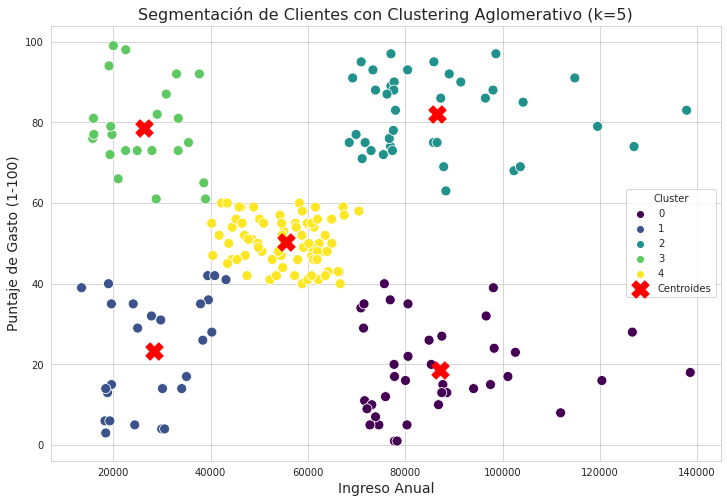

In [5]:
#Aplicación del Algoritmo de Clustering
n_clusters = 5
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = agg_cluster.fit_predict(X_scaled)

# Etiquetas
df['Cluster'] = labels

# CLusters
cluster_analysis = df.groupby('Cluster')[['Ingreso', 'Puntaje_Gasto']].mean().round(2)
cluster_analysis['N_Clientes'] = df['Cluster'].value_counts()
print("--- Análisis de los Clusters Encontrados ---")
print(cluster_analysis)
#Visualización de los Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Ingreso', y='Puntaje_Gasto', hue='Cluster', palette='viridis', s=100, legend='full')

# Añadir centroides
centroids = df.groupby('Cluster')[['Ingreso', 'Puntaje_Gasto']].mean()
plt.scatter(centroids['Ingreso'], centroids['Puntaje_Gasto'], s=300, c='red', marker='X', label='Centroides')

plt.title('Segmentación de Clientes con Clustering Aglomerativo (k=5)', fontsize=16)
plt.xlabel('Ingreso Anual', fontsize=14)
plt.ylabel('Puntaje de Gasto (1-100)', fontsize=14)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Estrategia de Marketing
Concentraría la estrategia de marketing en los siguientes tres grupos, en orden de prioridad, debido a su alto potencial de retorno:

1. Cluster superior derecha: Objetivo Ideal "Clientes VIP"

¿Por qué?: Este grupo es el más rentable. Tienen tanto la capacidad económica como la intención de gastar justificando una mayor inversión en marketing para atraerlos y retenerlos.

Estrategia Propuesta: Marketing de exclusividad, programas de lealtad premium, acceso anticipado a productos y atención personalizada.

2. Cluster superior izquierda: "Impulsivos"

¿Por qué?: A pesar de sus bajos ingresos, su altísima propensión al gasto los convierte en un motor clave para el volumen de ventas y la adopción de nuevos productos. Son el público perfecto para el marketing digital y viral.

3. Cluster inferior derecha:- "Los Ricos Prudentes"

¿Por qué?: Este grupo representa un potencial sin explotar. Tienen el dinero, pero no lo están gastando. Si logramos entender sus necesidades y convencerlos del valor de nuestros productos, podrían convertirse en un segmento tan rentable como los "Clientes VIP".

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

Justificación de min_samples: Se elige un valor de 5 basado en la regla 2*D (2*2=4), buscando clusters con una densidad mínima de 5 puntos.



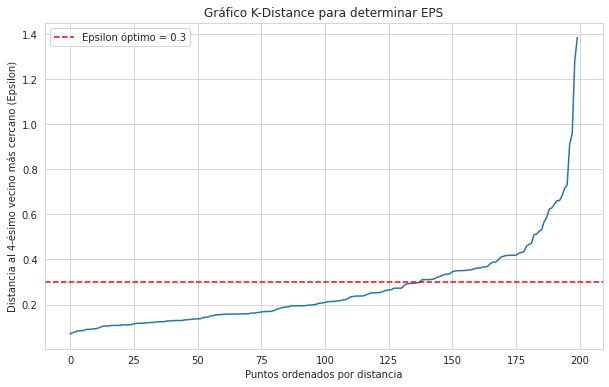

Justificación de eps: El gráfico K-distance muestra un 'codo' (punto de máxima inflexión) en aproximadamente y=0.3. Este valor representa el radio de vecindad donde la densidad de puntos cambia significativamente, siendo un candidato ideal para epsilon.

--- Resultados de DBSCAN ---
Número de clusters encontrados: 7
Número de puntos de ruido (outliers): 32

--- Análisis de los Clusters Encontrados (sin outliers) ---
                 Ingreso  Puntaje_Gasto  N_Clientes
Cluster_DBSCAN                                     
0               55330.36          48.58          88
1               22613.53          74.58          12
2               75269.34          83.32          22
3               83410.83          13.77          26
4               21971.12           7.78           9
5               92457.87          88.40           5
6               24210.83          33.67           6


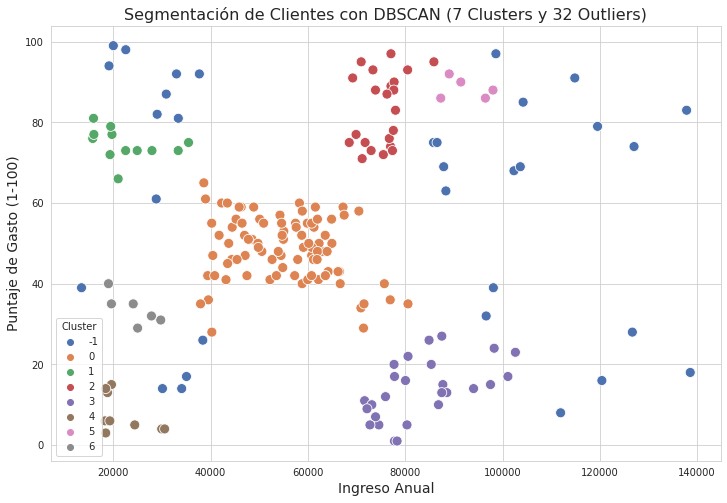

In [6]:
# Seleccionar las variables y estandarizarlas
X = df[['Ingreso', 'Puntaje_Gasto']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


# Justificación y Elección de Hiperparámetros ---
# Regla general: min_samples = 2 * número de dimensiones (D)
# En nuestro caso, D=2 (Ingreso, Puntaje_Gasto), por lo que min_samples = 2 * 2 = 4.
# Usaremos un valor cercano, min_samples = 5, para buscar clusters un poco más densos.
min_samples = 5
print(f"Justificación de min_samples: Se elige un valor de {min_samples} basado en la regla 2*D (2*2=4), buscando clusters con una densidad mínima de 5 puntos.\n")

# B. Elección de eps (Epsilon)
# Usamos el método del "gráfico de la rodilla" (K-distance plot).
# Calculamos la distancia de cada punto a su k-ésimo vecino más cercano (k = min_samples - 1).
k = min_samples - 1
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Tomamos la distancia al k-ésimo vecino (la última columna) y la ordenamos.
k_distances = np.sort(distances[:, k], axis=0)

# Graficar la curva para encontrar el "codo" o "rodilla"
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Puntos ordenados por distancia")
plt.ylabel(f"Distancia al {k}-ésimo vecino más cercano (Epsilon)")
plt.title("Gráfico K-Distance para determinar EPS")
# En esta gráfica, el codo se encuentra aproximadamente en 0.3.
eps = 0.3
plt.axhline(y=eps, color='r', linestyle='--', label=f'Epsilon óptimo = {eps}')
plt.legend()
plt.grid(True)
plt.show()
print(f"Justificación de eps: El gráfico K-distance muestra un 'codo' (punto de máxima inflexión) en aproximadamente y={eps}. Este valor representa el radio de vecindad donde la densidad de puntos cambia significativamente, siendo un candidato ideal para epsilon.\n")

# DBSCAN ---
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X_scaled)

# Añadir las nuevas etiquetas al DataFrame
df['Cluster_DBSCAN'] = labels

# --- 4. Análisis de los Resultados ---
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("--- Resultados de DBSCAN ---")
print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de puntos de ruido (outliers): {n_noise}\n")

# Características de los clusters encontrados
# Agrupamos por cluster, excluyendo a los outliers (cluster == -1)
cluster_analysis_dbscan = df[df['Cluster_DBSCAN'] != -1].groupby('Cluster_DBSCAN')[['Ingreso', 'Puntaje_Gasto']].mean().round(2)
cluster_analysis_dbscan['N_Clientes'] = df[df['Cluster_DBSCAN'] != -1]['Cluster_DBSCAN'].value_counts()
print("--- Análisis de los Clusters Encontrados (sin outliers) ---")
print(cluster_analysis_dbscan)

# --- 5. Visualización de los Clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Ingreso', y='Puntaje_Gasto', hue='Cluster_DBSCAN', palette='deep', s=100)

plt.title(f'Segmentación de Clientes con DBSCAN ({n_clusters} Clusters y {n_noise} Outliers)', fontsize=16)
plt.xlabel('Ingreso Anual', fontsize=14)
plt.ylabel('Puntaje de Gasto (1-100)', fontsize=14)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Procedimeinto**
1. Selección de Parámetros: A diferencia de otros métodos, primero se determinaron los hiperparámetros eps y min_samples. Se eligió min_samples=5 basado en la dimensionalidad de los datos, y se encontró un eps óptimo de aproximadamente 0.3 analizando el punto de inflexión ("codo") en un gráfico de K-distance.

2. Ejecución de DBSCAN: Con estos parámetros, el algoritmo DBSCAN recorrió los datos. Identificó regiones densas donde los puntos estaban muy juntos (formando clusters) y marcó como "ruido" u outliers.

**Lo que encontré**:
- Obtuve **7 grupos** principales de clientes

**Comparando con el clustering jerárquico que hice antes**:

*Lo que me gusta más de DBSCAN*:
- No tengo que decidir de antemano cuántos grupos quiero (se decide solo)
- Me separa automáticamente los clientes raros o atípicos
- Puede encontrar grupos de formas más extrañas, no solo círculos
- No se deja afectar tanto por los datos extremos

*¿Cambiaría mi estrategia de marketing?*:
Sí, definitivamente cambiaría mi estrategia comparado con el clustering jerárquico porque:

1. **Clientes atípicos identificados**: Ahora sé exactamente qué clientes son "diferentes" y necesitan un trato especial
2. **Grupos más limpios**: Los clusters que encontré son más "puros" porque están basados en densidad
3. **Más opciones**: Puedo hacer estrategias diferentes para clientes normales y para los atípicos

**Mi conclusión**: Creo que DBSCAN me da una mejor manera de segmentar a los clientes para marketing, especialmente porque me ayuda a identificar y manejar por separado a los clientes con comportamientos poco comunes.


### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

--- Variables seleccionadas para el clustering ---
    Ingreso  Puntaje_Gasto  Genero Grupo_Etario
0  98115.05             39   Mujer        35-44
1  35458.14             75   Mujer        18-24
2  59872.08             55   Mujer          65+
3  48508.93             51  Hombre        55-64
4  44431.11             54   Mujer        25-34

Tipos de datos verificados:
Ingreso          float64
Puntaje_Gasto      int64
Genero            object
Grupo_Etario      object
dtype: object

Calculando la matriz de distancia de Gower...
Matriz de distancia calculada exitosamente.

Justificación de min_samples: Se elige un valor de 8 (2*D = 2*4=8).


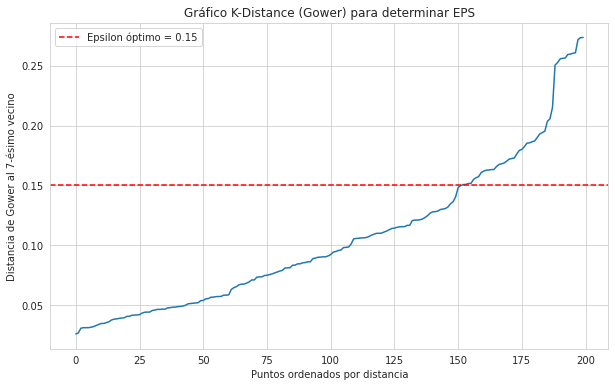

Justificación de eps: El gráfico K-distance muestra un 'codo' en y=0.15.

--- Resultados de DBSCAN con Distancia de Gower ---
Número de clusters encontrados: 10
Número de puntos de ruido (outliers): 19

--- Análisis de los Clusters Encontrados (con variables demográficas) ---
               Ingreso_Promedio  Gasto_Promedio Genero_Dominante  \
Cluster_Gower                                                      
0                      71073.04           43.86            Mujer   
1                      43869.87           62.94            Mujer   
2                      65815.38           63.66            Mujer   
3                      74110.30           70.89           Hombre   
4                      46748.48           51.88           Hombre   
5                      51366.81           46.00           Hombre   
6                      57470.00           24.50           Hombre   
7                      58029.13           34.36           Hombre   
8                      67001.99           5

In [7]:
# Crear la columna 'Grupo_Etario' si no existe
if 'Grupo_Etario' not in df.columns:
    bins = [17, 24, 34, 44, 54, 64, 100]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df['Grupo_Etario'] = pd.cut(df['Edad'], bins=bins, labels=labels, right=True)

# Seleccionar las 4 variables para el clustering
X_mixed = df[['Ingreso', 'Puntaje_Gasto', 'Genero', 'Grupo_Etario']].copy()
X_mixed['Grupo_Etario'] = X_mixed['Grupo_Etario'].astype(str)

print("--- Variables seleccionadas para el clustering ---")
print(X_mixed.head())
print("\nTipos de datos verificados:")
print(X_mixed.dtypes)

# --- 2. Cálculo de la Matriz de Distancia de Gower ---
print("\nCalculando la matriz de distancia de Gower...")
distance_matrix = gower.gower_matrix(X_mixed)
print("Matriz de distancia calculada exitosamente.")

# --- 3. Justificación y Elección de Hiperparámetros ---
min_samples = 8
print(f"\nJustificación de min_samples: Se elige un valor de {min_samples} (2*D = 2*4=8).")

k = min_samples - 1
nbrs = NearestNeighbors(n_neighbors=min_samples, metric='precomputed').fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)
k_distances = np.sort(distances[:, k], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.ylabel(f"Distancia de Gower al {k}-ésimo vecino")
plt.xlabel("Puntos ordenados por distancia")
plt.title("Gráfico K-Distance (Gower) para determinar EPS")
eps = 0.15 # Este valor se ajusta observando el "codo" del gráfico
plt.axhline(y=eps, color='r', linestyle='--', label=f'Epsilon óptimo = {eps}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Justificación de eps: El gráfico K-distance muestra un 'codo' en y={eps}.\n")

# --- 4. Aplicación del Algoritmo DBSCAN ---
dbscan_gower = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
labels = dbscan_gower.fit_predict(distance_matrix)

df['Cluster_Gower'] = labels

# --- 5. Análisis de los Resultados ---
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("--- Resultados de DBSCAN con Distancia de Gower ---")
print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de puntos de ruido (outliers): {n_noise}\n")

non_outliers = df[df['Cluster_Gower'] != -1]
cluster_summary = non_outliers.groupby('Cluster_Gower').agg(
    Ingreso_Promedio=('Ingreso', 'mean'),
    Gasto_Promedio=('Puntaje_Gasto', 'mean'),
    Genero_Dominante=('Genero', lambda x: x.mode()[0]),
    Grupo_Etario_Dominante=('Grupo_Etario', lambda x: x.mode()[0]),
    N_Clientes=('Ingreso', 'count')
).round(2)

print("--- Análisis de los Clusters Encontrados (con variables demográficas) ---")
print(cluster_summary)

**Procedimeinto**
1. Preparación se seleccionó un conjunto de cuatro variables para el análisis: dos numéricas (Ingreso, Puntaje_Gasto) y dos categóricas (Genero, Grupo_Etario). Para manejar esta mezcla de tipos de datos, se eligió la distancia de Gower, una métrica especializada que calcula de forma inteligente la similitud entre los clientes considerando todas las variables.

2. Cálculo de Distancias: Se generó una matriz de distancias utilizando la función de Gower, la cual contiene la "diferencia" calculada entre cada par de clientes en el conjunto de datos.

3. Ajuste de DBSCAN: Con la matriz de distancias ya calculada, se aplicó el algoritmo DBSCAN. min_samples: Se elige un valor de 8 (2*D = 2*4=8). eps: El gráfico K-distance muestra un 'codo' en y=0.15. La densidad de los datos en este nuevo espacio de 4 dimensiones, resultando en la identificación de clusters y outliers.

**Análisis de Resultados:**
En lugar de unos pocos grupos grandes, el algoritmo ha identificado 10 clusters mucho más pequeños y específicos, además de 19 outliers. Esto significa que los perfiles demográficos han permitido crear segmentos mucho más granulares y homogéneos.

¿Incorporar estas variables ayuda a la focalización de la estrategia de marketing?
Sí, de manera rotunda y fundamental. Pasar de 5 clusters genéricos a 10 clusters demográficamente definidos. La estrategia de marketing se vuelve exponencialmente más efectiva.